#### Imports

In [194]:
import math
import os
import re

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, apply_affine_transform

%matplotlib inline

In [195]:
data_dir = './../images/collected_images'

In [196]:
image_file_names = os.listdir(data_dir)

#### Analyze images and normalize class label

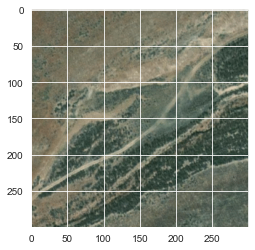

In [197]:
test_image = imread(f'{data_dir}/{image_file_names[0]}')
plt.imshow(test_image)

In [198]:
test_image.shape

(300, 300, 4)

In [199]:
test_image[:, :, 0]

array([[0.4509804 , 0.4509804 , 0.41960785, ..., 0.6431373 , 0.6666667 ,
        0.52156866],
       [0.41568628, 0.41568628, 0.44705883, ..., 0.67058825, 0.64705884,
        0.52156866],
       [0.4509804 , 0.44705883, 0.44705883, ..., 0.6431373 , 0.5803922 ,
        0.45490196],
       ...,
       [0.2901961 , 0.32156864, 0.39215687, ..., 0.3882353 , 0.38431373,
        0.35686275],
       [0.32156864, 0.38431373, 0.39215687, ..., 0.3882353 , 0.35686275,
        0.35686275],
       [0.32156864, 0.32156864, 0.39215687, ..., 0.38431373, 0.3882353 ,
        0.38431373]], dtype=float32)

In [200]:
image_file_names[0]

'WA_total_opportunity_1001.TIF_10022_0.0.png'

In [201]:
regex = re.compile('_([\d.e-]+)\.png')
regex.findall(image_file_names[0])[0]

'0.0'

In [202]:
image_dicts = []
length = len(image_file_names)
count = 1
for image_name in image_file_names:
    print(f'\r{count}/{length}', end='')
    row = {'name': image_name, 'value': float(regex.findall(image_name)[0])}
    image_dicts.append(row)
    count += 1
image_df = pd.DataFrame(image_dicts)

97704/97704

In [203]:
image_df

,name,value
0,WA_total_opportunity_1001.TIF_10022_0.0.png,0.000000
1,WA_total_opportunity_1001.TIF_10268_0.0.png,0.000000
2,WA_total_opportunity_1001.TIF_10477_0.0.png,0.000000
3,WA_total_opportunity_1001.TIF_10611_0.0.png,0.000000
4,WA_total_opportunity_1001.TIF_10648_0.0.png,0.000000
...,...,...
97699,WA_total_opportunity_999.TIF_9526_0.0.png,0.000000
97700,WA_total_opportunity_999.TIF_9536_0.0.png,0.000000
97701,WA_total_opportunity_999.TIF_9571_0.0.png,0.000000
97702,WA_total_opportunity_999.TIF_968_0.0.png,0.000000


In [204]:
image_df['value']

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
97699    0.000000
97700    0.000000
97701    0.000000
97702    0.000000
97703    0.321836
Name: value, Length: 97704, dtype: float64

S:\deep-learning-on-ray\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

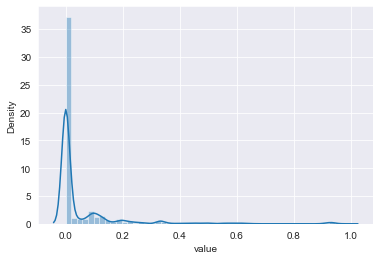

In [205]:
sns.distplot(image_df['value'])

In [206]:
image_df['value'].describe()

count    97704.000000
mean         0.055980
std          0.139413
min          0.000000
25%          0.000000
50%          0.000000
75%          0.038075
max          0.982339
Name: value, dtype: float64

In [207]:
sample_size = int(np.floor(len(image_df[image_df['value'] == 0.0]) * .99))

In [208]:
sample = np.random.choice(image_df[image_df['value'] == 0.0].index, size=sample_size, replace=False)
len(sample)

54591

In [209]:
# remove sample of images with no reforestation opp from input data
shortened_image_df = image_df.drop(sample)

In [210]:
shortened_image_df.describe()

,value
count,43113.000000
mean,0.126864
std,0.187227
min,0.000000
25%,0.004489
50%,0.071310
75%,0.140421
max,0.982339


S:\deep-learning-on-ray\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

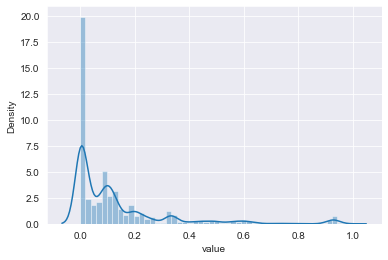

In [211]:
sns.distplot(shortened_image_df['value'])

In [220]:
def bin_values(frame, column):
    frame['binned_value'] = np.round(frame[column], decimals=1)
    frame['binned_value'] = frame['binned_value'] * 10
    frame['binned_value'] = pd.DataFrame.astype(frame['binned_value'], dtype=int)
    frame['binned_value'] = pd.DataFrame.astype(frame['binned_value'], dtype=str)
    return frame

In [221]:
shortened_image_df = bin_values(shortened_image_df, 'value')

In [222]:
shortened_image_df

,name,value,binned_value
16,WA_total_opportunity_1001.TIF_1155_0.137539257...,0.137539,1
17,WA_total_opportunity_1001.TIF_1156_0.191021614...,0.191022,2
31,WA_total_opportunity_1001.TIF_12575_0.67119896...,0.671199,7
35,WA_total_opportunity_1001.TIF_12905_0.67119896...,0.671199,7
46,WA_total_opportunity_1001.TIF_13564_0.65058193...,0.650582,7
...,...,...,...
97685,WA_total_opportunity_999.TIF_8403_0.1375392573...,0.137539,1
97686,WA_total_opportunity_999.TIF_8407_0.3210973582...,0.321097,3
97689,WA_total_opportunity_999.TIF_8865_0.1375392573...,0.137539,1
97693,WA_total_opportunity_999.TIF_9015_0.1375392573...,0.137539,1


In [223]:
type(shortened_image_df['binned_value'].iloc[0])

str

In [99]:
# def right_angle_rotate(input_image):
#     angle = np.random.choice([0, 90, 180, 270])
#     if angle != 0:
#         input_image = apply_affine_transform(
#             input_image, theta=angle)
#     return input_image

In [224]:
image_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    # preprocessing_function=right_angle_rotate,
    validation_split=0.3,
    rescale=1/255
)

train_generator = image_datagen.flow_from_dataframe(
    dataframe=shortened_image_df,
    directory=data_dir,
    target_size=(300, 300),
    x_col='name',
    y_col='binned_value',
    color_mode='grayscale',
    batch_size=1,
    seed=42,
    class_mode='categorical',
    subset='training'
)

test_generator = train_generator = image_datagen.flow_from_dataframe(
    dataframe=shortened_image_df,
    directory=data_dir,
    target_size=(300, 300),
    x_col='name',
    y_col='binned_value',
    color_mode='grayscale',
    batch_size=1,
    seed=42,
    class_mode='categorical',
    subset='validation'
)

Found 30180 validated image filenames belonging to 11 classes.
Found 12933 validated image filenames belonging to 11 classes.


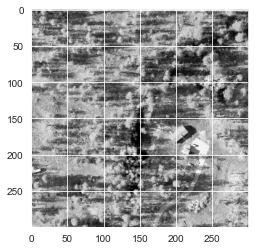

In [225]:
plt.imshow(train_generator[0][0][0].reshape(300, 300), cmap='gray')

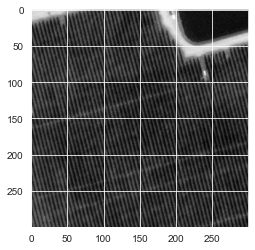

In [226]:
plt.imshow(train_generator[10][0][0].reshape(300, 300), cmap='gray')

#### Train model

In [232]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(10,10), strides=10, input_shape=(300, 300, 1), activation='relu',))
model.add(MaxPooling2D(pool_size=(25, 25)))

# model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
# model.add(MaxPooling2D(pool_size=(2, 2)))
#
# model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
# model.add(MaxPooling2D(pool_size=(2, 2)))
#
# model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
# model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

# model.add(Dense(2048, activation = 'relu'))
#
# model.add(Dense(1024, activation = 'relu'))

model.add(Dense(128, activation = 'relu'))

# model.add(Dropout(0.5))

model.add(Dense(11))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [233]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        3232      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 128)               4224      
                                                                 
 dense_9 (Dense)             (None, 11)                1419      
                                                                 
 activation_4 (Activation)   (None, 11)                0         
                                                      

In [234]:
model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20
)
model.save(f'./../models/ncrp_reforestation_{model.name}.h5')

Epoch 1/20
12933/12933 [==============================] - 59s 5ms/step - loss: 0.2188 - accuracy: 0.4212 - val_loss: 0.2132 - val_accuracy: 0.4618
Epoch 2/20
12933/12933 [==============================] - 48s 4ms/step - loss: 0.2114 - accuracy: 0.4563 - val_loss: 0.2096 - val_accuracy: 0.4627
Epoch 3/20
12933/12933 [==============================] - 50s 4ms/step - loss: 0.2098 - accuracy: 0.4681 - val_loss: 0.2090 - val_accuracy: 0.4724
Epoch 4/20
12933/12933 [==============================] - 51s 4ms/step - loss: 0.2073 - accuracy: 0.4788 - val_loss: 0.2069 - val_accuracy: 0.4795
Epoch 5/20
12933/12933 [==============================] - 49s 4ms/step - loss: 0.2052 - accuracy: 0.4918 - val_loss: 0.2013 - val_accuracy: 0.5094
Epoch 6/20
12933/12933 [==============================] - 48s 4ms/step - loss: 0.2033 - accuracy: 0.5005 - val_loss: 0.1987 - val_accuracy: 0.5126
Epoch 7/20
12933/12933 [==============================] - 48s 4ms/step - loss: 0.2017 - accuracy: 0.5065 - val_loss: 0